This script is used to retreive all available NHM data from within the Delaware River Basin and store outputs as CSV files.

The method follows:
1.0 Get the IDs for all segments in the DRB
    1.1 Load the USGS geospatial fabric (GFv1.1) and DRB boundary
    1.2 Clip the GF using the boundary to identify all DRB relevant info.
2.0 Load and extract the NHM data of interest
    2.1 Load the .tar and get file members
    2.2 Extract files of interest
    2.3 Filter the data for DRB relevant values
3.0 Export CSVs



DATA:

The Geospatial Fabric (GFv1.1) data (1GB) is available here:
https://www.sciencebase.gov/catalog/item/5e29d1a0e4b0a79317cf7f63


The NHM-PRMS data must be downloaded here:
https://www.sciencebase.gov/catalog/item/5d826f6ae4b0c4f70d05913f

WARNING: The .tar file needed to retrieve NHM data is 92GB.  

In [ ]:
import tarfile
# import netCDF4 as nc
# import xarray
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import itertools

pywrdrb_dir = '../Pywr-DRB/'
sys.path.append(pywrdrb_dir)

from pywrdrb.pywr_drb_node_data import nhm_site_matches, immediate_downstream_nodes_dict, obs_pub_site_matches

# Constants
cms_to_mgd = 22.82
cm_to_mg = 264.17/1e6
cfs_to_mgd = 0.64631688969744

In [ ]:
# Load DRB and GF geospatial
crs = 4386
drb = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
gf = gpd.read_file(f'./GFv1.1.gdb/').to_crs(crs)
# gf_poi = gpd.read_file(f'./gfv11/gfv11.shp').to_crs(crs)

# Load metadata
nhm_to_gf_hru = pd.read_csv('./data/nhm_to_GFv1.1_HRU.csv', sep =',')
nhm_to_gf_seg = pd.read_csv('./data/nhm_to_GFv1.1_SEG.csv', sep =',')

nhm_gage_ids = pd.read_csv("./data/poi_gage_id.csv", index_col=0)
nhm_seg_ids = pd.read_csv("./data/poi_gage_segment.csv", index_col=0)


nhm_gage_segments = pd.concat([nhm_gage_ids, nhm_seg_ids], axis=1)
nhm_gage_segments.columns = ['gage_id', 'nhm_segment_id']
nhm_gage_segments['gage_id'] = [f'0{site_id}' for site_id in nhm_gage_segments['gage_id'].values]


<Axes: >

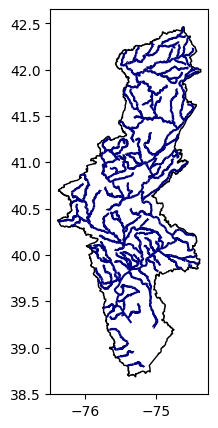

In [ ]:
# Clip the GF to DRB
gf_drb = gpd.clip(gf, drb)
# gf_poi_drb = gpd.clip(gf_poi, drb)

# Store & export DRB relevant segment IDs
drb_segment_ids = gf_drb['nsegment_v1_1']
drb_nhm_gage_segments = nhm_gage_segments.loc[nhm_gage_segments['nhm_segment_id'].isin(drb_segment_ids)]
drb_nhm_gage_segments.to_csv('./outputs/drb_nhm_gage_segment_ids.csv', sep=',')

# Visualize the clip
ax = drb.plot(facecolor = 'none', edgecolor = 'black', figsize = (3,5))
gf_drb.plot(ax=ax, color = 'navy')
# gf_poi_drb.plot(ax=ax, color = 'darkgreen', markersize = 4)

## Step 2: Data extraction

The following cell is used to extract the NHM modeled streamflow timeseries from the `byHRU_musk_obs.tar` file containing NHM data for the CONUS.

**This step requires access to the 92+ GB `.tar` file... however the extraction has already been performed and does NOT need to be repeated. All NHM data within the DRB is stored in `./outputs/csv/drb_seg_outflow_mgd.csv`.**

In [ ]:
## Example of how to extract streamflow data from NHM-PRMS
import tarfile
import netCDF4 as nc
import pandas as pd

tar = tarfile.open('your_data_directory/byHRU_musk_obs.tar')

# Extract just the segment outflow
tar.extract('seg_outflow', path= './extracted/')

# Open the extracted netCDF 
segment_outflow = nc.Dataset(f'./extracted/seg_outflow.nc')

# Store values and segment IDs
vals = segment_outflow['seg_outflow'][:]
segment_ids = segment_outflow['segment'][:]

# Make a dataframe and pull just segments (ComIDs)  of interest
segment_outflow_df = pd.DataFrame(vals, columns = segment_ids)

In [4]:
## Load the NHM data
# .tar file location
re_extract = False
if re_extract:
    data_dir = 'C:/Users/tja73/Downloads'

    # Open and store file names
    tar = tarfile.open(f'{data_dir}/byHRU_musk_obs.tar')
    all_names = tar.getnames()
    all_members = tar.getmembers()

    # Extract just the NetCDF values of interest
    extract_member_indices = [7, 33, 36]
    extract_files = ['hru_outflow', 'seg_outflow', 'seg_upstream_inflow']

    for i in extract_member_indices:
        tar.extract(all_members[i], path = './outputs/')
    tar.close()

    ## HRU Outflow
    hru_data = nc.Dataset(f'./outputs/netcdf/hru_outflow.nc')

    # Store values
    vals = hru_data['hru_outflow'][:]
    hru_ids = hru_data['hru'][:]

    # Make a dataframe
    time_index = pd.date_range('1980-10-01', periods = 13241, freq = 'D')
    hru_outflow_df = pd.DataFrame(vals, index = time_index, columns = hru_ids)

    # Pull just DRB locations
    drb_hru_outflow = hru_outflow_df.loc[:, drb_segment_ids] * cfs_to_mgd

    # Export
    drb_hru_outflow.to_csv('./outputs/csv/drb_hru_outflow_mgd.csv', sep = ',')

    
    ## Segment Outflow
    seg_data = nc.Dataset(f'./outputs/netcdf/seg_outflow.nc')

    # Store values
    vals = seg_data['seg_outflow'][:]
    seg_ids = seg_data['segment'][:]

    # Make a dataframe
    seg_outflow_df = pd.DataFrame(vals, index = time_index, columns = seg_ids)

    # Pull just DRB locations
    drb_seg_outflow = seg_outflow_df.loc[:, drb_segment_ids] * cfs_to_mgd

    # Export
    drb_seg_outflow.to_csv('./outputs/csv/drb_seg_outflow_mgd.csv', sep = ',')
    drb_seg_outflow.to_hdf(f'./outputs/hdf/drb_seg_outflow_mgd.hdf5', key = 'df', mode = 'w')

In [5]:
# # Store and save geospatial info for the basin
# drb_nhm_ids = gf_poi_drb.loc[:, ['prvdr_d', 'n2_REACHC', 'n2_COMI']]
# drb_nhm_ids.columns = ['nhm_id', 'reachcode', 'comid']

# # Add long-lat
# drb_nhm_ids['long'] = gf_poi_drb.geometry.x
# drb_nhm_ids['lat'] = gf_poi_drb.geometry.y

# drb_nhm_ids = drb_nhm_ids.reset_index(inplace=False).drop(['index'], axis=1)
# drb_nhm_ids.to_csv('./outputs/nhm_poi_ids.csv', sep = ',')

We want to extract modeled flows at (1) the sites that are used in the Pywr-DRB model (listed in the `nhm_site_matches`) and (2) the flows at POIs (points of interest) corresponding to reservoir inflow gauge locations. 

The NHM streamflows at the `nhm_site_matches` are used as reservoir inflows/inputs for a `pywrdrb` model run. The streamflow timeseries at these nodes will be exported to input data directory for the Pywr-DRB model, as well as locally in the `./outputs/csv/` folder and will be called `streamflow_daily_nhmv10_mgd.csv` 

The POI streamflows are used to develop inflow scaling relationships for the historic reconstruction. 

In [6]:
## Retrieve and export Pywr-DRB nodal inflows
# Load the segment outflow which was previous extracted
drb_seg_outflow = pd.read_hdf(f'./outputs/hdf/drb_seg_outflow_mgd.hdf5', key = 'df')

## Retrieve just Pywr-DRB relevant flows
# Node inflows
pywr_drb_sites = []
for sites in nhm_site_matches.values():
    for s in sites:
        pywr_drb_sites.append(s)

# NHM flows that match gages in PywrDRB (Points of Interest)
for node, gage_ids in obs_pub_site_matches.items():
    if gage_ids:
        for g_id in gage_ids:
            nhm_gage_poi_id = drb_nhm_gage_segments[drb_nhm_gage_segments.gage_id == g_id].nhm_segment_id
            if len(nhm_gage_poi_id) > 0:
                print(f'NHM equivalent POI {nhm_gage_poi_id.values[0]} found for {node}')
                pywr_drb_sites.append(str(nhm_gage_poi_id.values[0]))

pywr_drb_nhm_flows = drb_seg_outflow.loc[:, pywr_drb_sites]

# Get rid of duplicate column from `delDRCanal` and `delTrenton`
pywr_drb_nhm_flows = pywr_drb_nhm_flows.T.drop_duplicates().T

# Export
pywr_drb_nhm_flows.to_csv(f'./outputs/csv/streamflow_daily_nhmv10_mgd.csv', sep = ',')
pywr_drb_nhm_flows.to_csv(f'{pywrdrb_dir}input_data/modeled_gages/streamflow_daily_nhmv10_mgd.csv', sep = ',')

NHM equivalent POI 1556 found for cannonsville
NHM equivalent POI 1559 found for cannonsville
NHM equivalent POI 1440 found for pepacton
NHM equivalent POI 1441 found for pepacton
NHM equivalent POI 1443 found for pepacton
NHM equivalent POI 1437 found for pepacton
NHM equivalent POI 1586 found for prompton
NHM equivalent POI 1703 found for beltzvilleCombined
NHM equivalent POI 1684 found for fewalter
NHM equivalent POI 1683 found for fewalter
NHM equivalent POI 2290 found for greenLane
NHM equivalent POI 2289 found for greenLane
